In [1]:
import matplotlib.pyplot as plt
import math
import torch
import numpy as np
from tqdm import trange

from utils.distributions import SumOfGaussians
from utils.plotting_utils import create_3d_hist, create_3d_hist_flat

#define our distribution
mean0 = torch.FloatTensor([2, 2])
mean1 = torch.FloatTensor([-1, 1])
d = len(mean0)

covar0 = torch.FloatTensor([[2, 0],[0, 1]])
covar1 = torch.FloatTensor([[0.5, 0.0],[0, 3]])

mixing_parameter = 0.4
sog_dis = SumOfGaussians([mean0, mean1], [covar0, covar1], [mixing_parameter, 1.0 - mixing_parameter])

In [2]:
#density calculation
x_min = -5
x_max = 5
y_min = -5
y_max = 5

grid_x, grid_y = torch.meshgrid(torch.linspace(x_min, x_max,100), torch.linspace(y_min, y_max,100), indexing='ij')
probs = torch.zeros_like(grid_x)
for i in trange(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        x = grid_x[i,j]
        y = grid_y[i,j]
        xy = torch.stack([x, y], dim=0)
        probs[i,j] = sog_dis.prob(xy)


100%|██████████| 100/100 [00:02<00:00, 40.68it/s]


[]

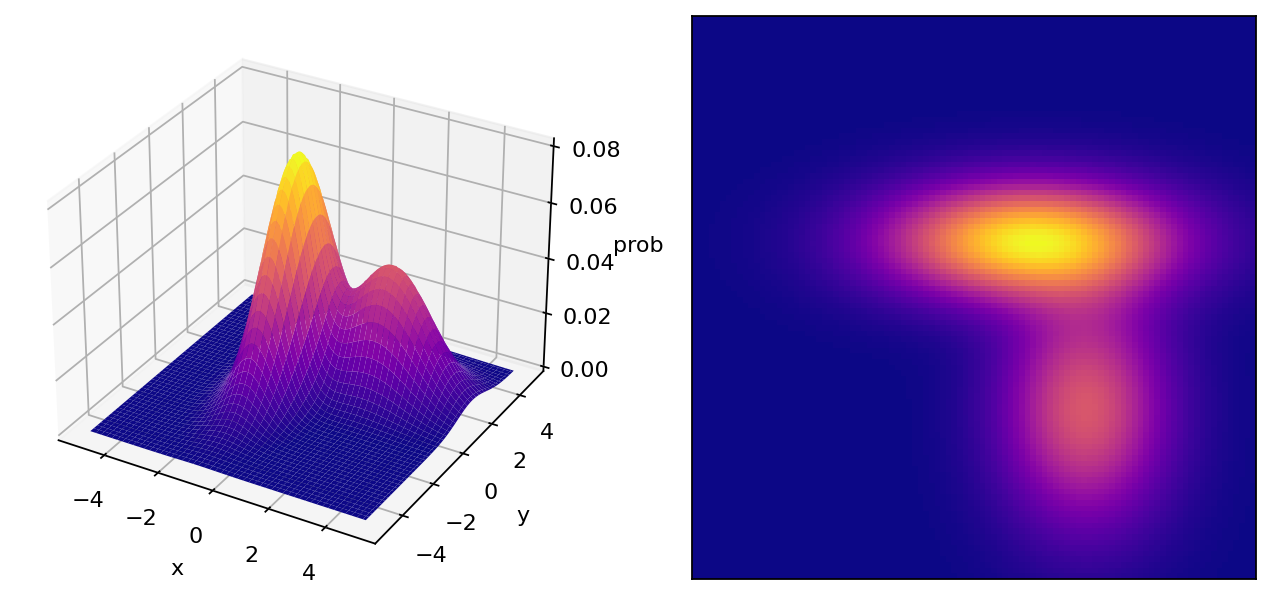

In [3]:
#density plot
def plot_density(ax):
    ax.plot_surface(grid_x, grid_y, probs, cmap='plasma', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('prob')

fig = plt.figure(figsize=(10, 5), dpi=160)
ax = fig.add_subplot(121, projection='3d')
plot_density(ax)

ax = fig.add_subplot(122)
ax.imshow(probs,  cmap='plasma')
ax.set_xticks([])
ax.set_yticks([])


In [4]:
#exact samples
num_samples = 500_000

gt_samples = sog_dis.sample(num_samples)

In [7]:
#Langevin samples
sampling_steps = 1_000
time_step = 1.0
#https://abdulfatir.com/blog/2020/Langevin-Monte-Carlo/
#https://en.wikipedia.org/wiki/Stochastic_gradient_Langevin_dynamics
samples = 2 * torch.randn((num_samples, d))

with torch.enable_grad():
    for k in trange(sampling_steps):
        samples.requires_grad_(True)
        log_p_x = sog_dis.log_prob(samples)
        torch.sum(log_p_x).backward()
        score = samples.grad
        noise = torch.randn((num_samples,d))

        with torch.no_grad():
            step_k = time_step * (0.5 + math.cos(math.pi * k / sampling_steps) / 2)
            samples = samples + step_k * score  + math.sqrt(2*step_k) * noise
            samples.grad = None


100%|██████████| 1000/1000 [00:44<00:00, 22.58it/s]


Text(0.5, 1.0, 'Estimated density - Langevin Samples')

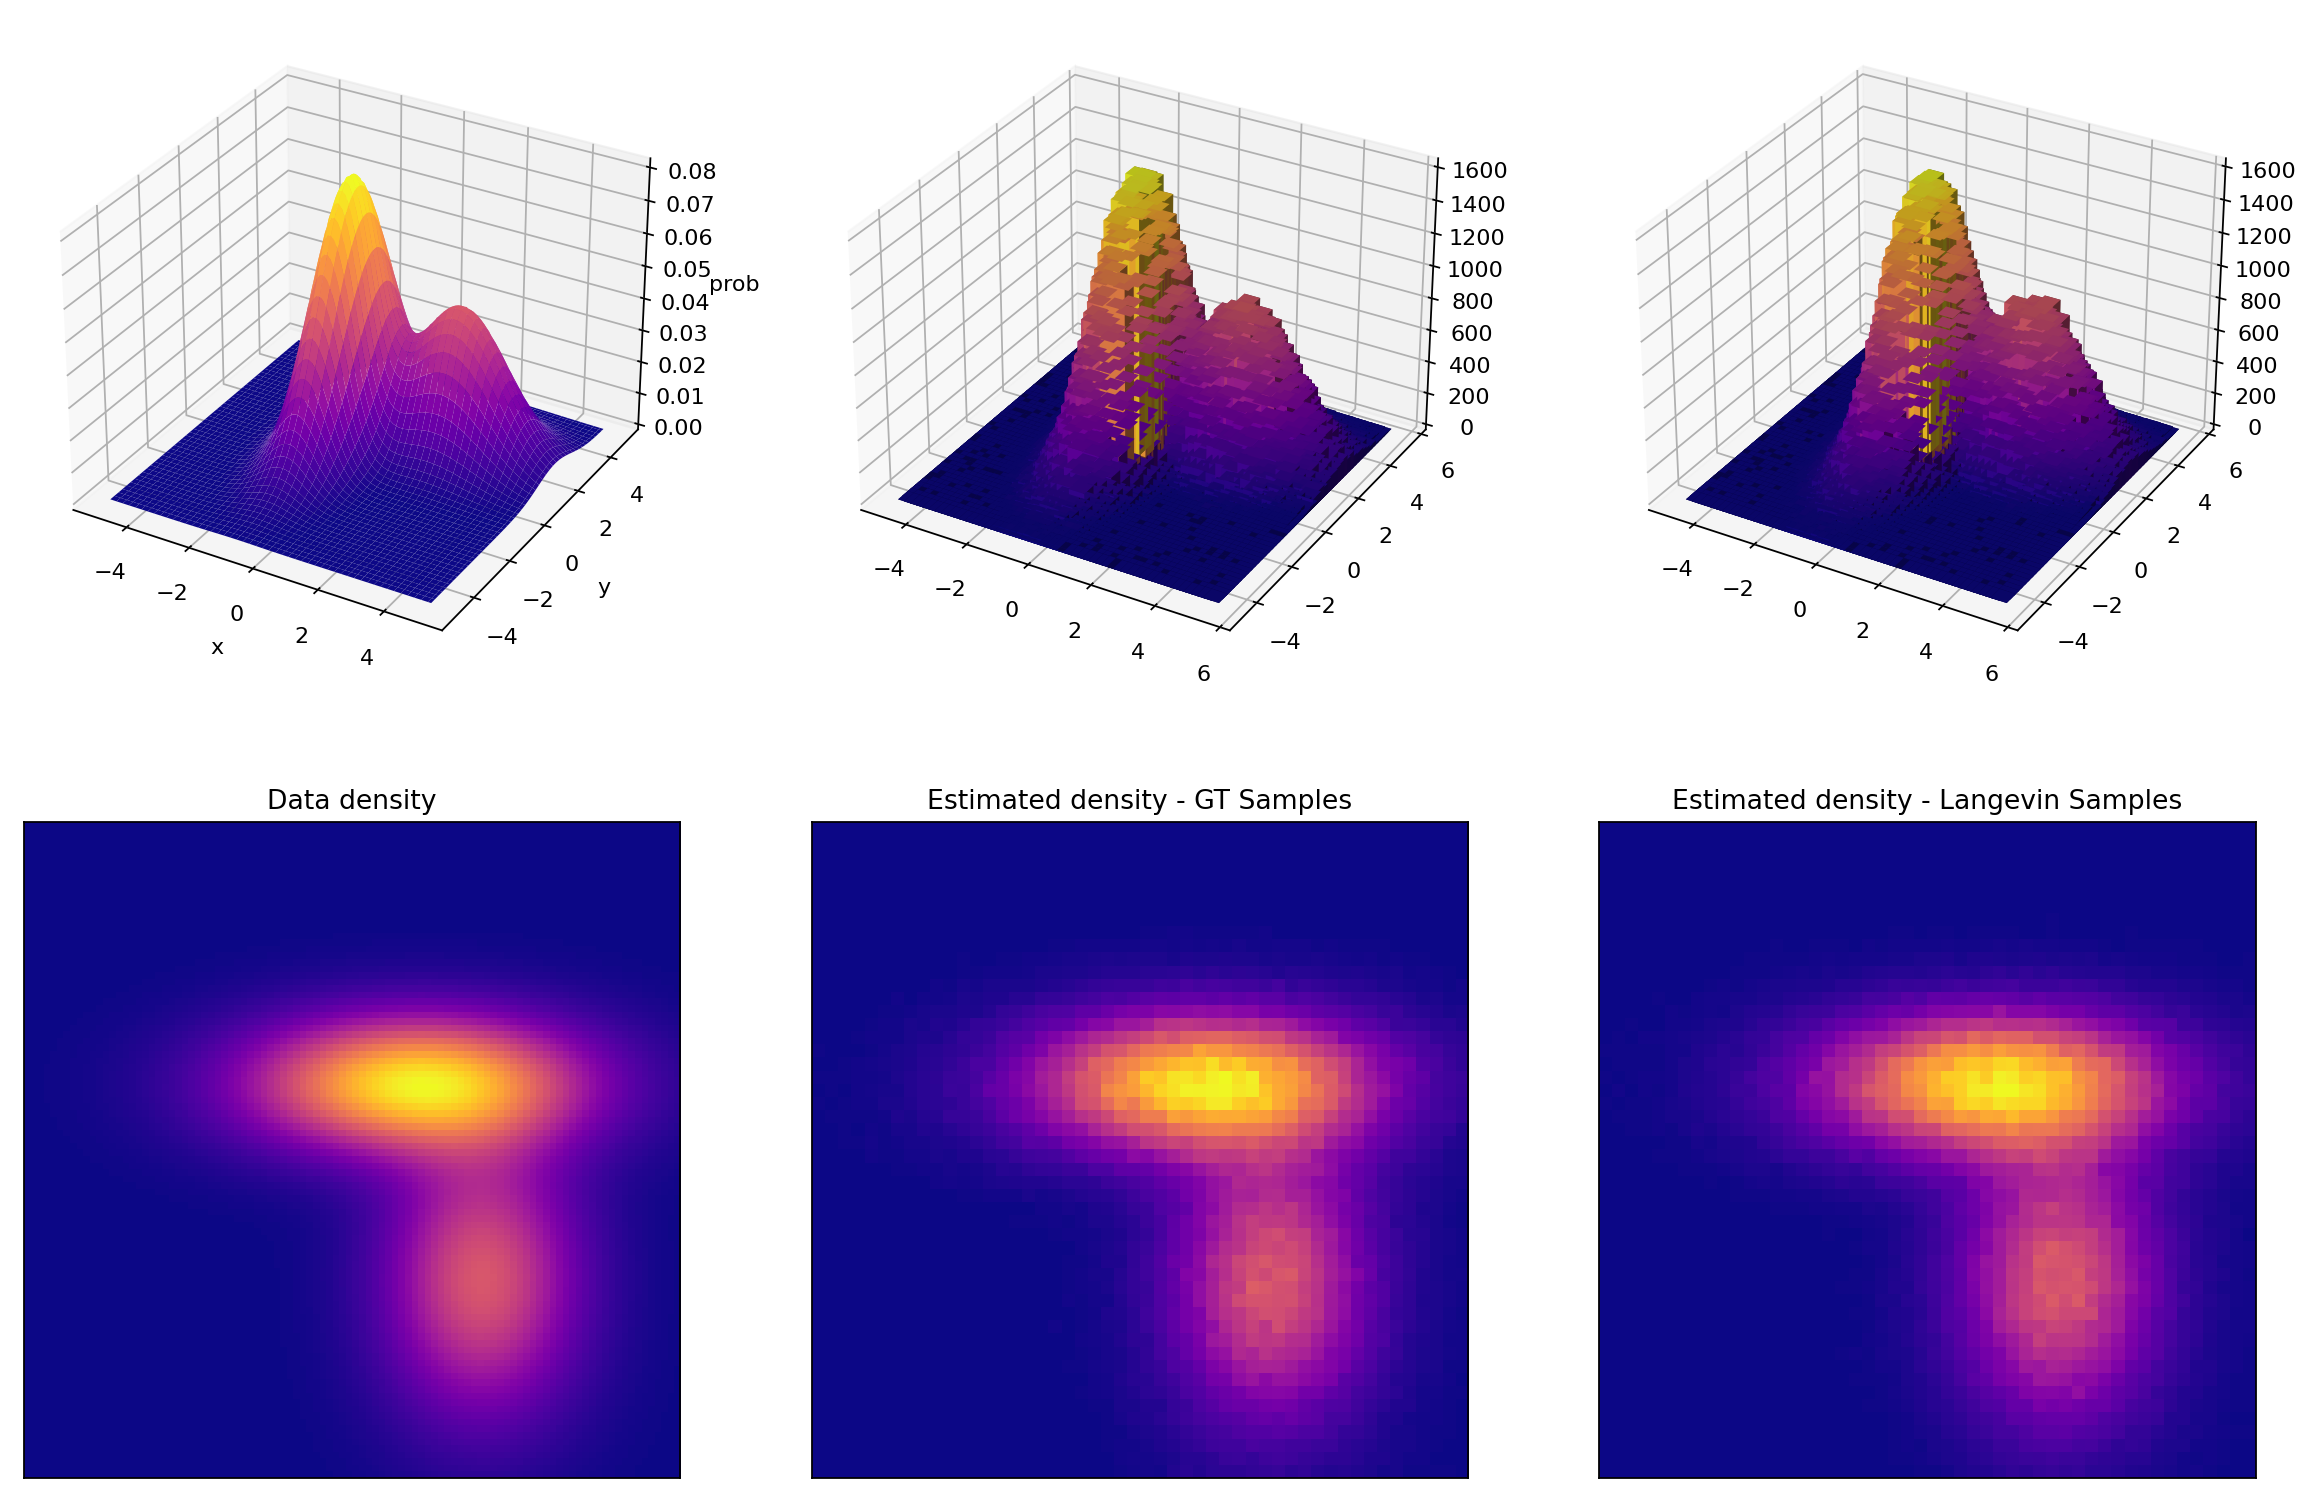

In [10]:
#visualize samples
fig = plt.figure(figsize=(18, 12), dpi=160)
ax = fig.add_subplot(231, projection='3d')
plot_density(ax)

ax = fig.add_subplot(232, projection='3d')
create_3d_hist(ax, gt_samples, x_min, x_max, y_min, y_max)

ax = fig.add_subplot(233, projection='3d')
create_3d_hist(ax, samples, x_min, x_max, y_min, y_max)

ax = fig.add_subplot(234)
ax.imshow(probs,  cmap='plasma')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Data density')

ax = fig.add_subplot(235)
create_3d_hist_flat(ax,  gt_samples, x_min, x_max, y_min, y_max)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Estimated density - GT Samples')

ax = fig.add_subplot(236)
create_3d_hist_flat(ax,  samples, x_min, x_max, y_min, y_max)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Estimated density - Langevin Samples')
